# VR CO2 Study - Data processing

This notebook does the following:

1. x
2. y
3. z

Input: input
Output: output

In [1]:
import pandas as pd
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils.Tests import Tests
from utils.plots import Plots
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import utils.graph_functions

In [2]:
# Create new directory for notebook output
notebook_temp_dir = os.path.join(os.getcwd(), "temp", "3_statistics")

if not os.path.exists(notebook_temp_dir):
    os.makedirs(notebook_temp_dir)

In [3]:
# File containing features for entire segments
segment_features_file = 'F:\co2-study\\temp\\segment_features.csv'
segment_features = pd.read_csv(segment_features_file, index_col=0)

# File containing features for windows of data
windowed_features_file = 'F:\co2-study\\temp\\windowed_features.csv'
windowed_features = pd.read_csv(windowed_features_file, index_col=0)

In [4]:
new_columns = [col.replace('[', '_').replace(']', '').replace('/', '_') for col in segment_features.columns]

# Assign the new column names to the DataFrame
segment_features.columns = new_columns
windowed_features.columns = new_columns

In [5]:
# Filter the data for 'air' and 'co2' conditions with 'gas_inhalation' segment
gas_inhalation_segments = segment_features[(segment_features['Condition'].isin(['AIR', 'CO2'])) & (segment_features['Segment'] == 'gas_inhalation')]
gas_inhalation_windows = windowed_features[(windowed_features['Condition'].isin(['AIR', 'CO2'])) & (windowed_features['Segment'] == 'gas_inhalation')]
gas_inhalation_segments = gas_inhalation_segments.dropna()
gas_inhalation_windows = gas_inhalation_windows.dropna()

# Calculate mean combined pupil size using left and right pupils
gas_inhalation_segments['pupil_size_combined'] = (gas_inhalation_segments['VerboseData.Left.PupilDiameterMm_mean'] + gas_inhalation_segments['VerboseData.Right.PupilDiameterMm_mean']) / 2
gas_inhalation_windows['pupil_size_combined'] = (gas_inhalation_windows['VerboseData.Left.PupilDiameterMm_mean'] + gas_inhalation_windows['VerboseData.Right.PupilDiameterMm_mean']) / 2

# add window index for each participant/condition
window_index = pd.DataFrame({'window_index': gas_inhalation_windows.groupby(['participant_number', 'Condition']).cumcount()})
gas_inhalation_windows.insert(3, 'window_index', window_index['window_index'])
#gas_inhalation_segments = gas_inhalation_segments.dropna()
#gas_inhalation_windows = gas_inhalation_windows.dropna()


# GSR


In [6]:
# Filter GSR data for segmented and windowed data
gsr_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Biopac_GSR_)').reset_index(drop=True)
gsr_air_segments = gsr_data_segments[gsr_data_segments['Condition']=='AIR']
gsr_co2_segments = gsr_data_segments[gsr_data_segments['Condition']=='CO2']

gsr_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Biopac_GSR_)').reset_index(drop=True)
gsr_air_windows = gsr_data_windows[gsr_data_windows['Condition']=='AIR']
gsr_co2_windows = gsr_data_windows[gsr_data_windows['Condition']=='CO2']

In [7]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(gsr_air_segments['Biopac_GSR_mean'], 'AIR')
Tests.normality_test_sw(gsr_co2_segments['Biopac_GSR_mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9097617268562317
Shapiro-Wilk Test - p-value: 0.0017018801299855113
Data for AIR condition is NOT normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.9044846892356873
Shapiro-Wilk Test - p-value: 0.0011468266602605581
Data for CO2 condition is NOT normally distributed.


ShapiroResult(statistic=0.9044846892356873, pvalue=0.0011468266602605581)

In [8]:
# 
Tests.paired_t_test(gsr_air_segments['Biopac_GSR_mean'],gsr_co2_segments['Biopac_GSR_mean'])

T-statistic: -8.538
P-value: 0.000
SIGNIFICANT difference found.


(-8.538469607064895, 5.748323645578251e-11)

In [32]:
Plots.segment_violin(gsr_data_segments, 'Biopac_GSR_mean', 'Mean GSR for Air and CO2 Conditions', 'Condition', 'GSR', 
                    notebook_temp_dir)

In [10]:
from statsmodels.stats.anova import AnovaRM

test_data = gsr_data_windows[['participant_number', 'Condition', 'window_index', 'Biopac_GSR_mean']]

In [11]:
import pandas as pd

# Assuming your data is in a DataFrame called test_data

# Pivot the data to long format
long_data = test_data.pivot(index=['participant_number'], columns=['Condition', 'window_index'], values='Biopac_GSR_mean')

# Reset the index to make 'participant_number' a regular column
long_data = long_data.reset_index()

# Flatten the column hierarchy
long_data.columns = ['_'.join(map(str, col)) for col in long_data.columns]

long_data = long_data.round(3)

# Display the long format data
long_data.to_csv(os.path.join(notebook_temp_dir, 'GSR_data'))


In [12]:
#air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(gsr_air_windows, gsr_co2_windows, gsr_data_windows, 'Biopac_GSR_mean', 2)

In [13]:
filtered_data = gas_inhalation_windows.dropna()
# Calculate participant counts
participant_counts = filtered_data['participant_number'].value_counts()

# Identify participants with counts below 230
participants_below_230 = participant_counts[participant_counts < 230].index

# Filter out participants with counts below 230
filtered_data = filtered_data[~filtered_data['participant_number'].isin(participants_below_230)]

In [23]:
Plots.features_time_series_gsr2(filtered_data, 'Biopac_GSR_mean', 'GSR Mean Over Time', 'Time (minutes)', 'GSR', utils.graph_functions.quadratic_function, utils.graph_functions.logistic_function, 
                          os.path.join(notebook_temp_dir, "GSR_mean_over_time"))

CO2 Logistic Equation: y = 0.6635193094888204 / (1 + e^(-0.16729908588356934 * (x - 2.6436570287458934)))
AIR Quadratic Equation: y = 3.114341495396642e-05 * (x - 55.30989205215323)^2 + 0.22640425725542587


In [467]:
mean_gsr = filtered_data.groupby(['Condition', 'window_index'])['Biopac_GSR_mean'].mean().reset_index()
air_gsr_mean = mean_gsr['Biopac_GSR_mean'][mean_gsr['Condition']=='AIR']
co2_gsr_mean = mean_gsr['Biopac_GSR_mean'][mean_gsr['Condition']=='CO2']
# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(air_gsr_mean, co2_gsr_mean)
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: -0.6119217132550423
P-value: 3.719815207082084e-13


# RSP


In [33]:
# RSP
rsp_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|window_index|Biopac_RSP_|RSP_)').reset_index(drop=True)
rsp_air_segments = rsp_data_segments[rsp_data_segments['Condition']=='AIR']
rsp_co2_segments = rsp_data_segments[rsp_data_segments['Condition']=='CO2']

rsp_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Biopac_RSP_|RSP_)').reset_index(drop=True)
rsp_air_windows = rsp_data_windows[rsp_data_windows['Condition']=='AIR']
rsp_co2_windows = rsp_data_windows[rsp_data_windows['Condition']=='CO2']

In [34]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(rsp_air_segments['RSP_Rate_Mean'], 'AIR')
Tests.normality_test_sw(rsp_co2_segments['RSP_Rate_Mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9675655364990234
Shapiro-Wilk Test - p-value: 0.22444088757038116
Data for AIR condition is  normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.9650021195411682
Shapiro-Wilk Test - p-value: 0.1791263073682785
Data for CO2 condition is  normally distributed.


ShapiroResult(statistic=0.9650021195411682, pvalue=0.1791263073682785)

In [35]:
Tests.paired_t_test(rsp_air_segments['RSP_Rate_Mean'],rsp_co2_segments['RSP_Rate_Mean'])

T-statistic: -14.216
P-value: 0.000
SIGNIFICANT difference found.


(-14.21639544143445, 2.9644907837639765e-18)

In [36]:
Plots.segment_violin(rsp_data_segments, 'RSP_Rate_Mean', 'Mean Respiratory Rate for Air and CO2 Conditions', 'Condition', 'Respiratory Rate', 
                    notebook_temp_dir)

In [28]:
#air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(rsp_air_windows, rsp_co2_windows, rsp_data_windows, 'RSP_Rate_Mean', 2)

In [29]:
filtered_data = gas_inhalation_windows.dropna()
# Calculate participant counts
participant_counts = filtered_data['participant_number'].value_counts()

# Identify participants with counts below 230
participants_below_230 = participant_counts[participant_counts < 230].index

# Filter out participants with counts below 230
filtered_data = filtered_data[~filtered_data['participant_number'].isin(participants_below_230)]

CO2 Logistic Equation: y = 22.02812185601398 / (1 + e^(-0.05662630776458537 * (x - -6.008167556316287)))
AIR Straight Line Equation: y = 0.007383302188392786 * x + 12.715461517825643


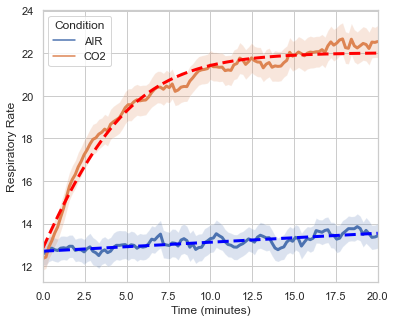

In [32]:

Plots.features_time_series_rr(filtered_data, 'RSP_Rate_Mean', 'RSP Rate Mean Over Time', 'Time (minutes)', 'Respiratory Rate', utils.graph_functions.straight_line_function, utils.graph_functions.logistic_function, 
                          os.path.join(notebook_temp_dir, "RSP_mean_over_time"))

In [31]:
mean_rsp = gas_inhalation_windows.groupby(['Condition', 'window_index'])['RSP_Rate_Mean'].mean().reset_index()
air_rsp_mean = mean_rsp['RSP_Rate_Mean'][mean_rsp['Condition']=='AIR']
co2_rsp_mean = mean_rsp['RSP_Rate_Mean'][mean_rsp['Condition']=='CO2']
# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(air_rsp_mean, co2_rsp_mean)
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.7602506675992692
P-value: 6.637753665119911e-23


# HR


In [37]:
# HR
#TODO: Using emteqPRO's HR because feature extraction when using entire segments sets HR features to nan per outlier rejection
hr_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|PPG_|HRV_|HeartRate_Average_mean)').reset_index(drop=True)
hr_data_segments.rename(columns = {'HeartRate/Average_mean':'HeartRate_Average_mean'}, inplace = True)
hr_air_segments = hr_data_segments[hr_data_segments['Condition']=='AIR']
hr_co2_segments = hr_data_segments[hr_data_segments['Condition']=='CO2']

hr_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|PPG_|HRV_|HeartRate_Average_mean)').reset_index(drop=True)
hr_data_windows.rename(columns = {'HeartRate/Average_mean':'HeartRate_Average_mean'}, inplace = True)
hr_air_windows = hr_data_windows[hr_data_windows['Condition']=='AIR']
hr_co2_windows = hr_data_windows[hr_data_windows['Condition']=='CO2']

In [38]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(hr_air_segments['PPG_Rate_Mean'], 'AIR')
Tests.normality_test_sw(hr_co2_segments['PPG_Rate_Mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9768682718276978
Shapiro-Wilk Test - p-value: 0.48405978083610535
Data for AIR condition is  normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.9863318800926208
Shapiro-Wilk Test - p-value: 0.8591641783714294
Data for CO2 condition is  normally distributed.


ShapiroResult(statistic=0.9863318800926208, pvalue=0.8591641783714294)

In [39]:
Tests.paired_t_test(hr_air_segments['HeartRate_Average_mean'],hr_co2_segments['PPG_Rate_Mean'])

T-statistic: -45.533
P-value: 0.000
SIGNIFICANT difference found.


(-45.532907553866664, 2.755483963788822e-39)

In [40]:
Plots.segment_violin(hr_data_segments, 'PPG_Rate_Mean', 'Mean Heart Rate for Air and CO2 Conditions', 'Condition', 'Heart Rate', 
                    notebook_temp_dir)

In [37]:
#air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(hr_air_windows, hr_co2_windows, hr_data_windows, 'PPG_Rate_Mean', 2)

CO2 Straight Line Equation: y = 0.14297063619398268 * x + 75.320127708956
AIR Straight Line Equation: y = 0.014906932312371224 * x + 75.7822010390582


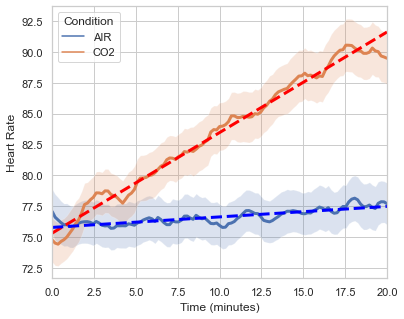

In [39]:
Plots.features_time_series_hr(gas_inhalation_windows, 'PPG_Rate_Mean', 'HR Rate Mean Over Time', 'Time (minutes)', 'Heart Rate', utils.graph_functions.straight_line_function, utils.graph_functions.straight_line_function, os.path.join(notebook_temp_dir, "HR_mean_over_time_PPG"))

In [330]:
mean_hr = gas_inhalation_windows.groupby(['Condition', 'window_index'])['PPG_Rate_Mean'].mean().reset_index()
air_hr_mean = mean_hr['PPG_Rate_Mean'][mean_hr['Condition']=='AIR']
co2_hr_mean = mean_hr['PPG_Rate_Mean'][mean_hr['Condition']=='CO2']
# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(air_hr_mean, co2_hr_mean)
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.2122888142963096
P-value: 0.022744399412355773


# Pupil Size

In [41]:
# Pupil size
pupil_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|VerboseData.|pupil_)').reset_index(drop=True)
#pupil_data_segments['pupil_size_combined'] = (pupil_data_segments['VerboseData.Left.PupilDiameterMm_mean'] + pupil_data_segments['VerboseData.Right.PupilDiameterMm_mean']) / 2

pupil_air_segments = pupil_data_segments[pupil_data_segments['Condition']=='AIR']
pupil_co2_segments = pupil_data_segments[pupil_data_segments['Condition']=='CO2']

pupil_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|VerboseData.|pupil_)').reset_index(drop=True)
pupil_air_windows = pupil_data_windows[pupil_data_windows['Condition']=='AIR']
pupil_co2_windows = pupil_data_windows[pupil_data_windows['Condition']=='CO2']

In [42]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(pupil_air_segments['pupil_size_combined'], 'AIR')
Tests.normality_test_sw(pupil_co2_segments['pupil_size_combined'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9481764435768127
Shapiro-Wilk Test - p-value: 0.03990786895155907
Data for AIR condition is NOT normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.977023184299469
Shapiro-Wilk Test - p-value: 0.48974671959877014
Data for CO2 condition is  normally distributed.


ShapiroResult(statistic=0.977023184299469, pvalue=0.48974671959877014)

In [43]:
Tests.paired_t_test(pupil_air_segments['pupil_size_combined'],pupil_co2_segments['pupil_size_combined'])

T-statistic: -1.527
P-value: 0.134
No singificant results found.


(-1.5266319540258766, 0.13385126981008785)

In [44]:
Plots.segment_violin(pupil_data_segments, 'pupil_size_combined', 'Pupil Size for Air and CO2 Conditions', 'Condition', 'Pupil Size', 
                    notebook_temp_dir)

In [447]:
#air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(pupil_air_windows, pupil_co2_windows, pupil_data_windows, 'pupil_size_combined', 2)

CO2 5th-Order Polynomial Equation: y = 1.0254187814217968e-09 * x^5 + -3.0834726454874236e-07 * x^4 + 3.248140133067844e-05 * x^3 + -0.0013408789753812172 * x^2 + 0.01467620095134821 * x + 0.7579865941072836
AIR Quadratic Equation: y = 1.7165230666314787e-05 * (x - 70.17557818775384)^2 + 0.6342247298881468


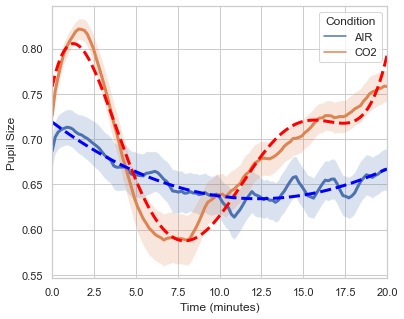

In [44]:
Plots.features_time_series_pupilsize(gas_inhalation_windows, 'pupil_size_combined', 'Pupil Size Mean Over Time', 'Time (minutes)', 'Pupil Size', utils.graph_functions.quadratic_function, utils.graph_functions.fifth_order, 
                          os.path.join(notebook_temp_dir, "Pupil_size"))

In [337]:
mean_ps = gas_inhalation_windows.groupby(['Condition', 'window_index'])['pupil_size_combined'].mean().reset_index()
air_ps_mean = mean_ps['pupil_size_combined'][mean_ps['Condition']=='AIR']
co2_ps_mean = mean_ps['pupil_size_combined'][mean_ps['Condition']=='CO2']
# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(air_ps_mean, co2_ps_mean)
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.6496421662572198
P-value: 4.019539499638744e-15


# EMG Contact

In [45]:
# Pupil size
contact_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Emg_Contact)').reset_index(drop=True)

#new_columns = [col.replace('[', '_').replace(']', '').replace('/', '_') for col in contact_data_segments.columns]

# Assign the new column names to the DataFrame
#contact_data_segments.columns = new_columns

contact_air_segments = contact_data_segments[contact_data_segments['Condition']=='AIR']
contact_co2_segments = contact_data_segments[contact_data_segments['Condition']=='CO2']

contact_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Emg_Contact)').reset_index(drop=True)

#new_columns = [col.replace('[', '_').replace(']', '').replace('/', '_') for col in contact_data_windows.columns]

# Assign the new column names to the DataFrame
#contact_data_windows.columns = new_columns

contact_air_windows = contact_data_windows[contact_data_windows['Condition']=='AIR']
contact_co2_windows = contact_data_windows[contact_data_windows['Condition']=='CO2']

In [46]:
# Shapiro-Wilk test for normality
Tests.normality_test_sw(contact_air_segments['Emg_Contact_CenterCorrugator_mean'], 'AIR')
Tests.normality_test_sw(contact_co2_segments['Emg_Contact_CenterCorrugator_mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.8956065773963928
Shapiro-Wilk Test - p-value: 0.0006020056316629052
Data for AIR condition is NOT normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.7860934734344482
Shapiro-Wilk Test - p-value: 9.666084679338383e-07
Data for CO2 condition is NOT normally distributed.


ShapiroResult(statistic=0.7860934734344482, pvalue=9.666084679338383e-07)

In [47]:
emg_mean_contact_columns = ['Emg_Contact_RightOrbicularis_mean', 'Emg_Contact_RightZygomaticus_mean', 'Emg_Contact_RightFrontalis_mean', 'Emg_Contact_CenterCorrugator_mean', 'Emg_Contact_LeftFrontalis_mean', 'Emg_Contact_LeftZygomaticus_mean', 'Emg_Contact_LeftOrbicularis_mean']
for mean_emg_column in emg_mean_contact_columns:
    print('Paired t-test for: ' + mean_emg_column)
    Tests.paired_t_test(contact_air_segments[mean_emg_column], contact_co2_segments[mean_emg_column])
    print("\n")

Paired t-test for: Emg_Contact_RightOrbicularis_mean
T-statistic: 3.512
P-value: 0.001
SIGNIFICANT difference found.


Paired t-test for: Emg_Contact_RightZygomaticus_mean
T-statistic: 4.244
P-value: 0.000
SIGNIFICANT difference found.


Paired t-test for: Emg_Contact_RightFrontalis_mean
T-statistic: 1.973
P-value: 0.055
No singificant results found.


Paired t-test for: Emg_Contact_CenterCorrugator_mean
T-statistic: 4.969
P-value: 0.000
SIGNIFICANT difference found.


Paired t-test for: Emg_Contact_LeftFrontalis_mean
T-statistic: 2.921
P-value: 0.005
SIGNIFICANT difference found.


Paired t-test for: Emg_Contact_LeftZygomaticus_mean
T-statistic: 2.363
P-value: 0.023
SIGNIFICANT difference found.


Paired t-test for: Emg_Contact_LeftOrbicularis_mean
T-statistic: 2.085
P-value: 0.043
SIGNIFICANT difference found.




In [48]:
# Perform regression tests with polynomial features
muscle_column = emg_mean_contact_columns[0]
air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(contact_air_windows, contact_co2_windows, contact_data_windows, muscle_column, 2)


Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Contact_RightOrbicularis_mean
AIR MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Contact_RightOrbicularis_mean
No. Observations: 5151    Method:             REML                             
No. Groups:       46      Scale:              0.0072                           
Min. group size:  49      Log-Likelihood:     5231.5039                        
Max. group size:  115     Converged:          Yes                              
Mean group size:  112.0                                                        
---------------------------------------------------------------------------------
                            Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                    0.479      0.036    13.371   0.000    0.409    0.549
w

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Contact_RightOrbicularis_mean
AIR MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Contact_RightOrbicularis_mean
No. Observations: 5151    Method:             REML                             
No. Groups:       46      Scale:              0.0072                           
Min. group size:  49      Log-Likelihood:     5231.5039                        
Max. group size:  115     Converged:          Yes                              
Mean group size:  112.0                                                        
---------------------------------------------------------------------------------
                            Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                    0.479      0.036    13.371   0.000    0.409    0.549
w

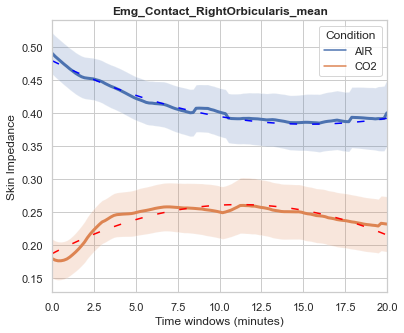

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Contact_RightZygomaticus_mean
AIR MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Contact_RightZygomaticus_mean
No. Observations: 5151    Method:             REML                             
No. Groups:       46      Scale:              0.0057                           
Min. group size:  49      Log-Likelihood:     5826.4959                        
Max. group size:  115     Converged:          Yes                              
Mean group size:  112.0                                                        
---------------------------------------------------------------------------------
                            Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                    0.530      0.041    13.054   0.000    0.451    0.610
w

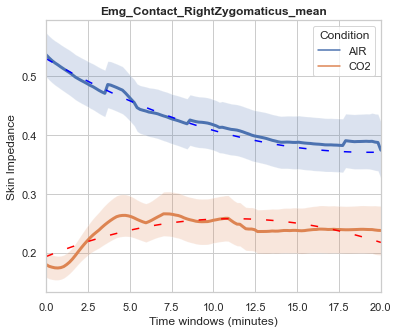

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Contact_RightFrontalis_mean
AIR MODEL
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Contact_RightFrontalis_mean
No. Observations: 5151    Method:             REML                           
No. Groups:       46      Scale:              0.0022                         
Min. group size:  49      Log-Likelihood:     8302.0525                      
Max. group size:  115     Converged:          Yes                            
Mean group size:  112.0                                                      
------------------------------------------------------------------------------
                              Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------------
Intercept                      0.222     0.030    7.420  0.000   0.164   0.281
window_index                

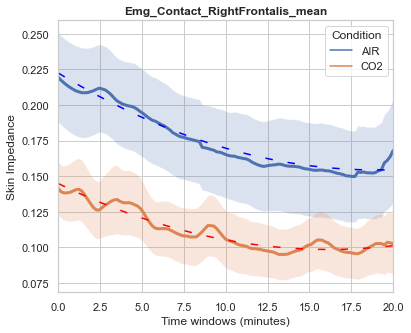

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Contact_CenterCorrugator_mean
AIR MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Contact_CenterCorrugator_mean
No. Observations: 5151    Method:             REML                             
No. Groups:       46      Scale:              0.0029                           
Min. group size:  49      Log-Likelihood:     7519.7883                        
Max. group size:  115     Converged:          Yes                              
Mean group size:  112.0                                                        
---------------------------------------------------------------------------------
                            Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                    0.389      0.033    11.890   0.000    0.325    0.453
w

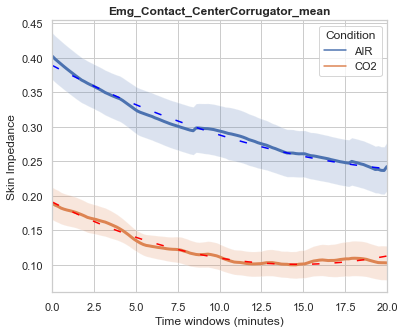

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Contact_LeftFrontalis_mean
AIR MODEL
                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Contact_LeftFrontalis_mean
No. Observations: 5151    Method:             REML                          
No. Groups:       46      Scale:              0.0030                        
Min. group size:  49      Log-Likelihood:     7435.2187                     
Max. group size:  115     Converged:          Yes                           
Mean group size:  112.0                                                     
-----------------------------------------------------------------------------
                             Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                     0.298     0.034    8.727  0.000   0.231   0.365
window_index                 -0.002     

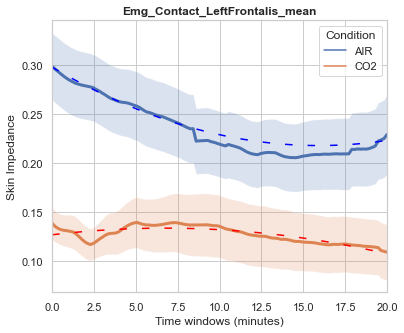

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Contact_LeftZygomaticus_mean
AIR MODEL
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Contact_LeftZygomaticus_mean
No. Observations: 5151    Method:             REML                            
No. Groups:       46      Scale:              0.0041                          
Min. group size:  49      Log-Likelihood:     6643.3924                       
Max. group size:  115     Converged:          Yes                             
Mean group size:  112.0                                                       
-------------------------------------------------------------------------------
                               Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                       0.536     0.037   14.561  0.000   0.464   0.608
window_index     

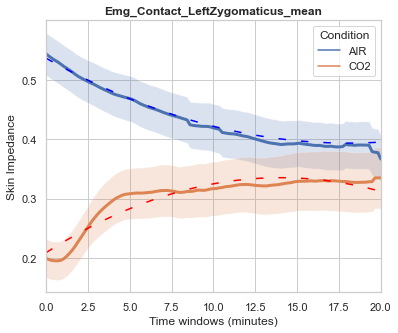

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Contact_LeftOrbicularis_mean
AIR MODEL
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Contact_LeftOrbicularis_mean
No. Observations: 5151    Method:             REML                            
No. Groups:       46      Scale:              0.0085                          
Min. group size:  49      Log-Likelihood:     4795.5407                       
Max. group size:  115     Converged:          Yes                             
Mean group size:  112.0                                                       
--------------------------------------------------------------------------------
                            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
--------------------------------------------------------------------------------
Intercept                    0.457      0.037   12.268   0.000    0.384    0.530
window_index 

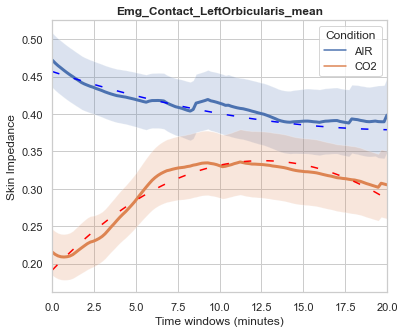

In [49]:
# Loop through each muscle column
for muscle_column in emg_mean_contact_columns:
    # Perform regression tests with polynomial features
    air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(contact_air_windows, contact_co2_windows, contact_data_windows, muscle_column, 2)
        
    # Create and save the time series plot
    Plots.features_time_series(gas_inhalation_windows, muscle_column, muscle_column, 'Time windows (minutes)', 'Skin Impedance', os.path.join(notebook_temp_dir, muscle_column), air_prediction_line, co2_prediction_line)

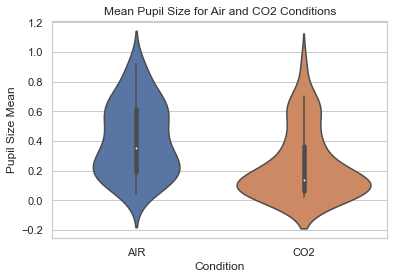

In [50]:
# Create the violin plot
sns.violinplot(x='Condition', y='Emg_Contact_RightOrbicularis_mean', data=contact_data_segments)

# Customize plot titles and labels
sns.set(style='whitegrid')
plt.title('Mean Pupil Size for Air and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('Pupil Size Mean')

# Display the plot
plt.show()

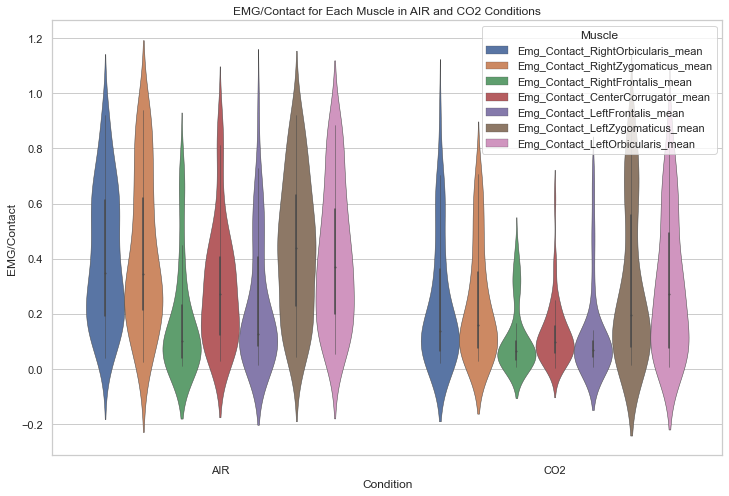

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = contact_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=emg_mean_contact_columns, var_name='Muscle', value_name='Emg_Contact')

# Define the order of the muscles for plotting
muscle_order = ['RightOrbicularis', 'RightZygomaticus', 'RightFrontalis', 'CenterCorrugator', 'LeftFrontalis', 'LeftZygomaticus', 'LeftOrbicularis']

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='Emg_Contact', hue='Muscle', data=melted_data, scale='width', linewidth=0.5)


# Customize the plot
plt.title('EMG/Contact for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('EMG/Contact')
plt.legend(title='Muscle')

plt.savefig(os.path.join(notebook_temp_dir, "contact_segments"))
# Show the plot
plt.show()


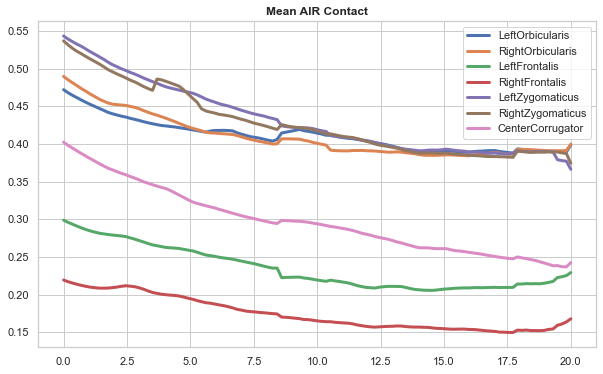

In [52]:
Plots.contact_muscles(contact_air_windows, os.path.join(notebook_temp_dir, "air_contact_windowed"))

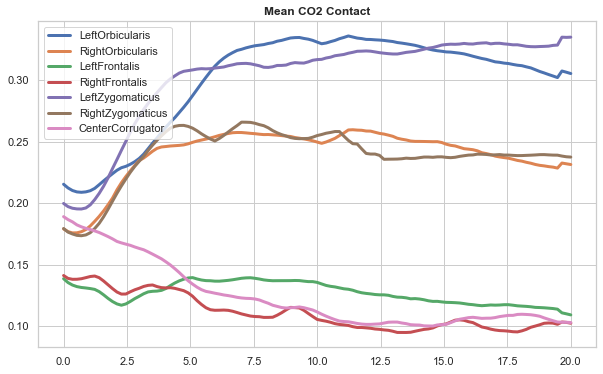

In [53]:
Plots.contact_muscles(contact_co2_windows, os.path.join(notebook_temp_dir, "co2_contact_windowed"))

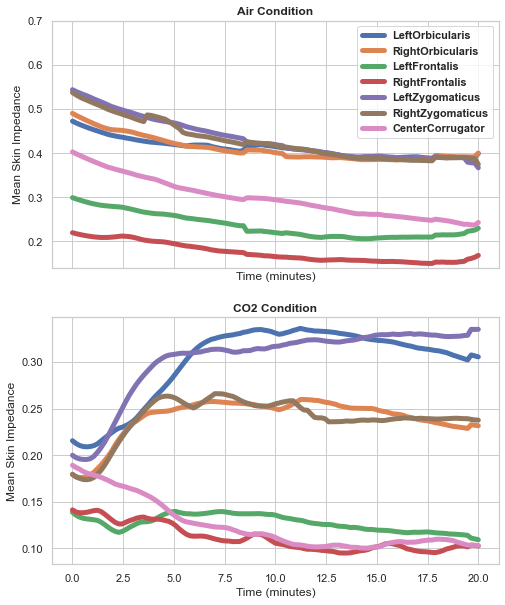

In [54]:
Plots.contact_muscles2(contact_air_windows, contact_co2_windows, os.path.join(notebook_temp_dir, "contact_combined"))

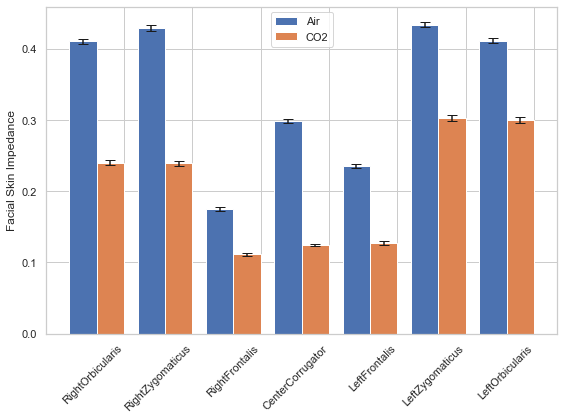

In [59]:
Plots.contact_barplot_with_se(contact_air_windows, contact_co2_windows, os.path.join(notebook_temp_dir, "contact_barplot"))

In [355]:
# Filter columns that contain "emg_contact" and "mean" in their names, and include "Biopac_Gsr_mean"
selected_columns = [col for col in gas_inhalation_windows.columns if "Emg_Contact" in col and "mean" in col and "_1st_derivative_mean" not in col and "_2nd_derivative_mean" not in col or col == "Biopac_GSR_mean" or col == "participant_number" or col == "Condition"]

# Create a new DataFrame with only the selected columns
filtered_data = gas_inhalation_windows[selected_columns]
filtered_data

,participant_number,Condition,Emg_Contact_RightOrbicularis_mean,Emg_Contact_RightZygomaticus_mean,Emg_Contact_RightFrontalis_mean,Emg_Contact_CenterCorrugator_mean,Emg_Contact_LeftFrontalis_mean,Emg_Contact_LeftZygomaticus_mean,Emg_Contact_LeftOrbicularis_mean,Biopac_GSR_mean
3,2_john,AIR,0.432086,0.868942,0.014954,0.211777,0.055572,0.405700,0.118216,0.425988
4,2_john,AIR,0.420912,0.866560,0.013325,0.207176,0.054724,0.398832,0.114531,0.375485
5,2_john,AIR,0.410062,0.863087,0.011191,0.202526,0.053675,0.393842,0.110802,0.299117
6,2_john,AIR,0.401265,0.863800,0.009072,0.198759,0.052776,0.392604,0.107662,0.235660
7,2_john,AIR,0.393712,0.866626,0.009060,0.196515,0.052280,0.400185,0.105327,0.225197
...,...,...,...,...,...,...,...,...,...,...
11521,63_reuben_moerman,CO2,0.198177,0.081598,0.017458,0.012225,0.032800,0.038122,0.020278,0.321676
11522,63_reuben_moerman,CO2,0.197811,0.080048,0.016228,0.010954,0.030782,0.034997,0.018524,0.323999
11523,63_reuben_moerman,CO2,0.197373,0.075944,0.014356,0.009530,0.027183,0.037494,0.016500,0.331552
11524,63_reuben_moerman,CO2,0.195743,0.070992,0.012544,0.008260,0.023976,0.036733,0.013774,0.336479


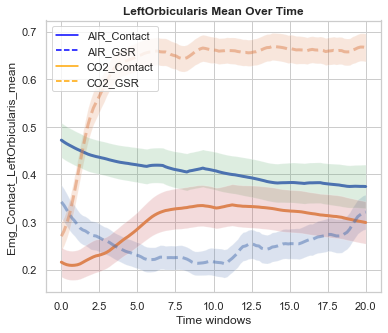

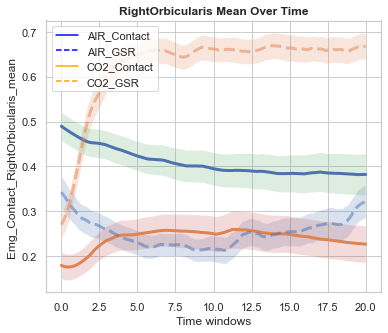

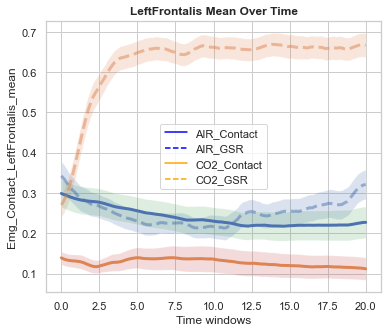

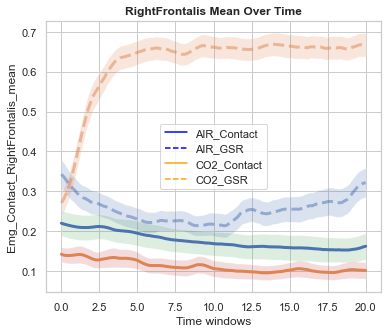

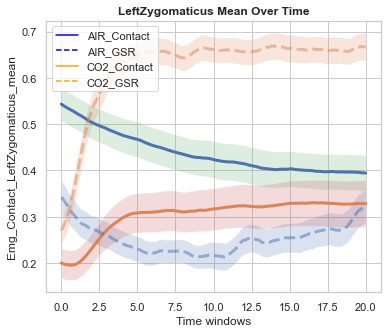

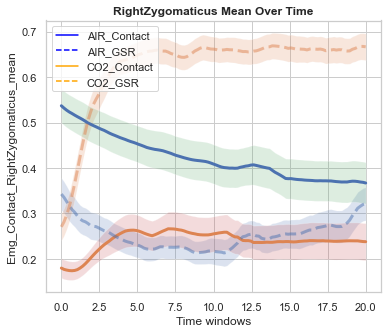

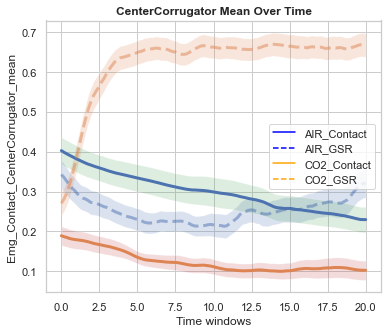

In [356]:
muscles = ['LeftOrbicularis','RightOrbicularis', 'LeftFrontalis', 'RightFrontalis', 'LeftZygomaticus', 'RightZygomaticus', 'CenterCorrugator']

for muscle in muscles:
    muscle_name = f'Emg_Contact_{muscle}_mean'
    plot_title = f'{muscle} Mean Over Time'
    Plots.contact_gsr_line_plot(gas_inhalation_windows, muscle_name, plot_title, notebook_temp_dir)


# EMG Amplitude

In [60]:
# Pupil size
amp_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Emg_Amplitude)').reset_index(drop=True)

amp_air_segments = amp_data_segments[amp_data_segments['Condition']=='AIR']
amp_co2_segments = amp_data_segments[amp_data_segments['Condition']=='CO2']

amp_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Emg_Amplitude)').reset_index(drop=True)
amp_air_windows = amp_data_windows[amp_data_windows['Condition']=='AIR']
amp_co2_windows = amp_data_windows[amp_data_windows['Condition']=='CO2']

In [61]:
# Shapiro-Wilk test for normality
Tests.normality_test_sw(amp_air_segments['Emg_Amplitude_RightOrbicularis_mean'], 'AIR')
Tests.normality_test_sw(amp_co2_segments['Emg_Amplitude_RightOrbicularis_mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.901692271232605
Shapiro-Wilk Test - p-value: 0.0009339679963886738
Data for AIR condition is NOT normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.8796755075454712
Shapiro-Wilk Test - p-value: 0.0002005763672059402
Data for CO2 condition is NOT normally distributed.


ShapiroResult(statistic=0.8796755075454712, pvalue=0.0002005763672059402)

In [62]:
# Paired t tests
emg_mean_amp_columns = ['Emg_Amplitude_RightOrbicularis_mean', 'Emg_Amplitude_RightZygomaticus_mean', 'Emg_Amplitude_RightFrontalis_mean', 'Emg_Amplitude_CenterCorrugator_mean', 'Emg_Amplitude_LeftFrontalis_mean', 'Emg_Amplitude_LeftZygomaticus_mean', 'Emg_Amplitude_LeftOrbicularis_mean']
for mean_amp_column in emg_mean_amp_columns:
    print('Paired t-test for: ' + mean_amp_column)
    Tests.paired_t_test(amp_air_segments[mean_amp_column], amp_co2_segments[mean_amp_column])
    print("\n")

Paired t-test for: Emg_Amplitude_RightOrbicularis_mean
T-statistic: -2.556
P-value: 0.014
SIGNIFICANT difference found.


Paired t-test for: Emg_Amplitude_RightZygomaticus_mean
T-statistic: -4.794
P-value: 0.000
SIGNIFICANT difference found.


Paired t-test for: Emg_Amplitude_RightFrontalis_mean
T-statistic: -1.100
P-value: 0.277
No singificant results found.


Paired t-test for: Emg_Amplitude_CenterCorrugator_mean
T-statistic: -1.427
P-value: 0.160
No singificant results found.


Paired t-test for: Emg_Amplitude_LeftFrontalis_mean
T-statistic: -1.068
P-value: 0.291
No singificant results found.


Paired t-test for: Emg_Amplitude_LeftZygomaticus_mean
T-statistic: -2.747
P-value: 0.009
SIGNIFICANT difference found.


Paired t-test for: Emg_Amplitude_LeftOrbicularis_mean
T-statistic: -2.031
P-value: 0.048
SIGNIFICANT difference found.




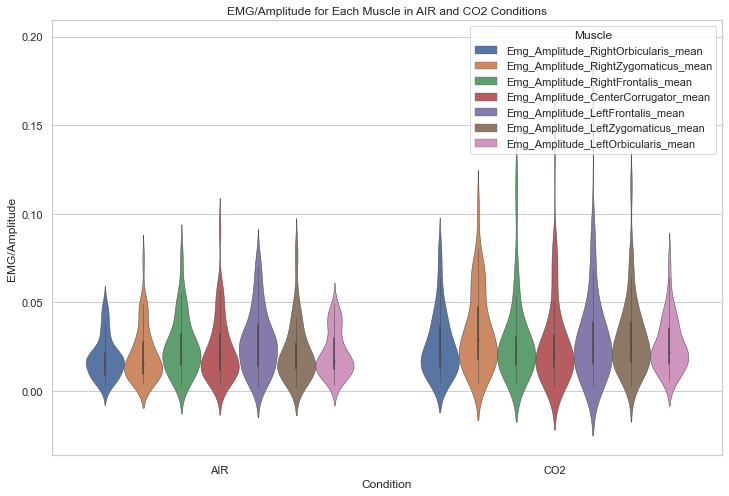

In [360]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = amp_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=emg_mean_amp_columns, var_name='Muscle', value_name='Emg_Amplitude')

# Define the order of the muscles for plotting
muscle_order = ['RightOrbicularis', 'RightZygomaticus', 'RightFrontalis', 'CenterCorrugator', 'LeftFrontalis', 'LeftZygomaticus', 'LeftOrbicularis']

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='Emg_Amplitude', hue='Muscle', data=melted_data, scale='width', linewidth=0.5)


# Customize the plot
plt.title('EMG/Amplitude for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('EMG/Amplitude')
plt.legend(title='Muscle')

plt.savefig(os.path.join(notebook_temp_dir, "amp_segments"))
# Show the plot
plt.show()


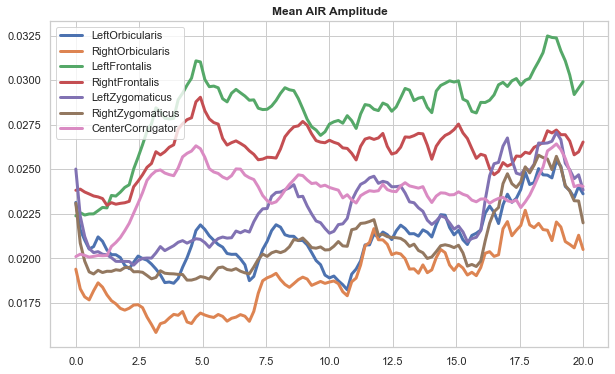

In [361]:
Plots.amp_muscles(amp_air_windows, os.path.join(notebook_temp_dir, "air_amp_windowed"))

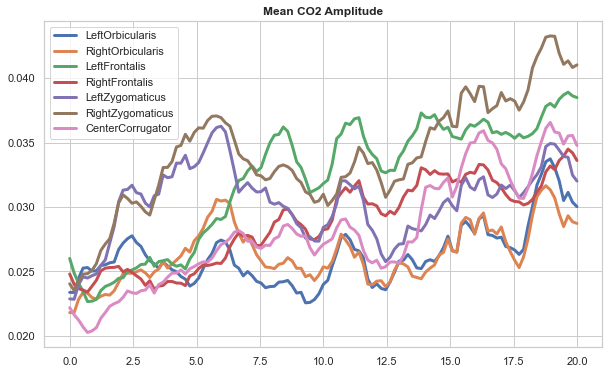

In [362]:
Plots.amp_muscles(amp_co2_windows, os.path.join(notebook_temp_dir, "co2_amp_windowed"))

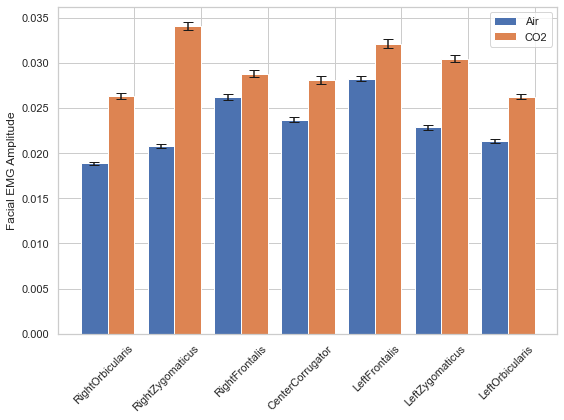

In [65]:
Plots.amp_barplot_with_se(amp_air_windows, amp_co2_windows, os.path.join(notebook_temp_dir, "amp_barplot"))

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Amplitude_RightOrbicularis_mean
AIR MODEL
                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_RightOrbicularis_mean
No. Observations: 5290    Method:             REML                               
No. Groups:       46      Scale:              0.0001                             
Min. group size:  115     Log-Likelihood:     17205.8866                         
Max. group size:  115     Converged:          Yes                                
Mean group size:  115.0                                                          
------------------------------------------------------------------------------------
                             Coef.    Std.Err.      z      P>|z|    [0.025    0.975]
------------------------------------------------------------------------------------
Intercept                    0.017       0.002    9.859    

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Emg_Amplitude_RightOrbicularis_mean in CO2 condition is on average higher by 0.007
COMBINED MODEL
                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_RightOrbicularis_mean
No. Observations: 10580   Method:             REML                               
No. Groups:       46      Scale:              0.0003                             
Min. group size:  230     Log-Likelihood:     28717.9462                         
Max. group size:  230     Converged:          Yes                                
Mean group size:  230.0                                                          
-------------------------------------------------------------------------------------
                        Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               0.017        0.002      9.443     0.000      0.013      0.020
Condit

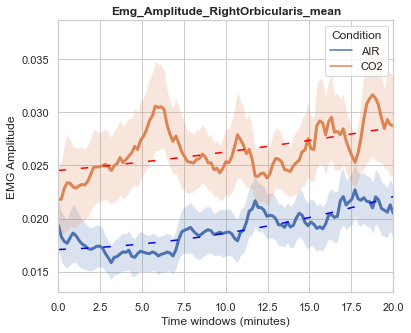

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Amplitude_RightZygomaticus_mean
AIR MODEL
                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_RightZygomaticus_mean
No. Observations: 5290    Method:             REML                               
No. Groups:       46      Scale:              0.0001                             
Min. group size:  115     Log-Likelihood:     16569.3842                         
Max. group size:  115     Converged:          Yes                                
Mean group size:  115.0                                                          
-----------------------------------------------------------------------------------
                               Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------------
Intercept                       0.020      0.002    8.720   0.

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_RightZygomaticus_mean
No. Observations: 5290    Method:             REML                               
No. Groups:       46      Scale:              0.0003                             
Min. group size:  115     Log-Likelihood:     13472.0375                         
Max. group size:  115     Converged:          Yes                                
Mean group size:  115.0                                                          
------------------------------------------------------------------------------------
                             Coef.    Std.Err.      z      P>|z|    [0.025    0.975]
------------------------------------------------------------------------------------
Intercept                    0.029       0.003    8.466    0.000     0.022     0.035
window_index                 0.000       0.000    2.273    0.023     0.000     0.000
np.power(window_index, 

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


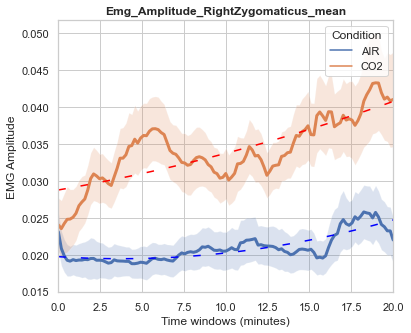

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Amplitude_RightFrontalis_mean
AIR MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_RightFrontalis_mean
No. Observations: 5290    Method:             REML                             
No. Groups:       46      Scale:              0.0001                           
Min. group size:  115     Log-Likelihood:     16090.7556                       
Max. group size:  115     Converged:          Yes                              
Mean group size:  115.0                                                        
---------------------------------------------------------------------------------
                             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                     0.024      0.003    9.478   0.000    0.019    0.029
w

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


CO2 MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_RightFrontalis_mean
No. Observations: 5290    Method:             REML                             
No. Groups:       46      Scale:              0.0002                           
Min. group size:  115     Log-Likelihood:     14921.2357                       
Max. group size:  115     Converged:          Yes                              
Mean group size:  115.0                                                        
---------------------------------------------------------------------------------
                             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                     0.023      0.004    6.410   0.000    0.016    0.030
window_index                  0.000      0.000    5.646   0.000    0.000    0.000
np.power(window_index, 2)    -0.000      

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


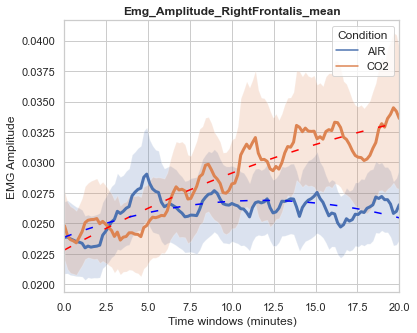

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Amplitude_CenterCorrugator_mean
AIR MODEL
                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_CenterCorrugator_mean
No. Observations: 5290    Method:             REML                               
No. Groups:       46      Scale:              0.0001                             
Min. group size:  115     Log-Likelihood:     16686.0808                         
Max. group size:  115     Converged:          Yes                                
Mean group size:  115.0                                                          
-----------------------------------------------------------------------------------
                               Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------------
Intercept                       0.022      0.003    8.167   0.

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Emg_Amplitude_CenterCorrugator_mean in CO2 condition is on average higher by 0.004
COMBINED MODEL
                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_CenterCorrugator_mean
No. Observations: 10580   Method:             REML                               
No. Groups:       46      Scale:              0.0003                             
Min. group size:  230     Log-Likelihood:     27526.7060                         
Max. group size:  230     Converged:          Yes                                
Mean group size:  230.0                                                          
-------------------------------------------------------------------------------------
                        Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               0.020        0.003      6.850     0.000      0.014      0.026
Condit

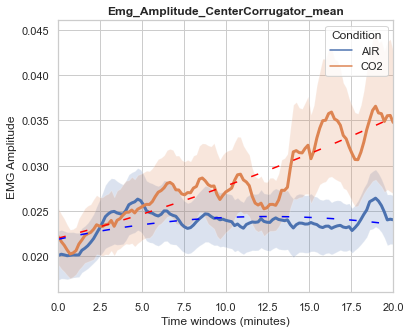

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Amplitude_LeftFrontalis_mean
AIR MODEL
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_LeftFrontalis_mean
No. Observations: 5290    Method:             REML                            
No. Groups:       46      Scale:              0.0002                          
Min. group size:  115     Log-Likelihood:     15526.1526                      
Max. group size:  115     Converged:          Yes                             
Mean group size:  115.0                                                       
--------------------------------------------------------------------------------
                            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
--------------------------------------------------------------------------------
Intercept                    0.024      0.003    8.954   0.000    0.019    0.030
window_index 

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


CO2 MODEL
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_LeftFrontalis_mean
No. Observations: 5290    Method:             REML                            
No. Groups:       46      Scale:              0.0003                          
Min. group size:  115     Log-Likelihood:     13534.8077                      
Max. group size:  115     Converged:          Yes                             
Mean group size:  115.0                                                       
--------------------------------------------------------------------------------
                            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
--------------------------------------------------------------------------------
Intercept                    0.022      0.004    4.932   0.000    0.013    0.031
window_index                 0.000      0.000    9.220   0.000    0.000    0.000
np.power(window_index, 2)   -0.000      0.000   -4.95

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


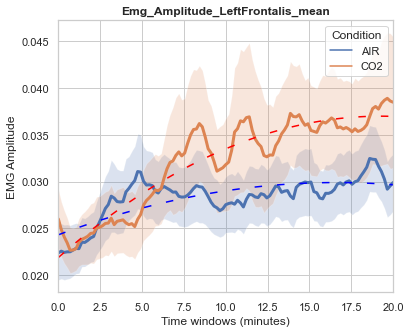

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Amplitude_LeftZygomaticus_mean
AIR MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_LeftZygomaticus_mean
No. Observations: 5290    Method:             REML                              
No. Groups:       46      Scale:              0.0002                            
Min. group size:  115     Log-Likelihood:     15304.1579                        
Max. group size:  115     Converged:          Yes                               
Mean group size:  115.0                                                         
----------------------------------------------------------------------------------
                                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
----------------------------------------------------------------------------------
Intercept                       0.020      0.003   7.828   0.000    0.015

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Emg_Amplitude_LeftZygomaticus_mean in CO2 condition is on average higher by 0.008
COMBINED MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_LeftZygomaticus_mean
No. Observations: 10580   Method:             REML                              
No. Groups:       46      Scale:              0.0003                            
Min. group size:  230     Log-Likelihood:     27940.4664                        
Max. group size:  230     Converged:          Yes                               
Mean group size:  230.0                                                         
------------------------------------------------------------------------------------
                       Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
------------------------------------------------------------------------------------
Intercept              0.021        0.003      8.097     0.000      0.016      0.026
Condition[T.CO2]  

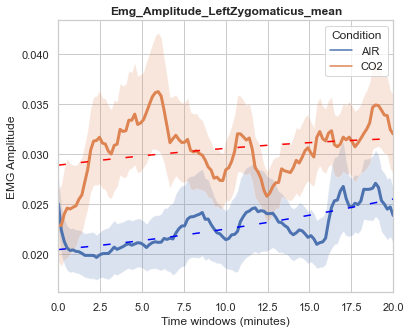

Running mixed polynomial regression model independently for air and co2 conditions for: Emg_Amplitude_LeftOrbicularis_mean
AIR MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_LeftOrbicularis_mean
No. Observations: 5290    Method:             REML                              
No. Groups:       46      Scale:              0.0001                            
Min. group size:  115     Log-Likelihood:     16782.7306                        
Max. group size:  115     Converged:          Yes                               
Mean group size:  115.0                                                         
----------------------------------------------------------------------------------
                              Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------------------
Intercept                      0.021      0.002   11.077   0.000    0.017

C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\masqu\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Emg_Amplitude_LeftOrbicularis_mean in CO2 condition is on average higher by 0.005
COMBINED MODEL
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emg_Amplitude_LeftOrbicularis_mean
No. Observations: 10580   Method:             REML                              
No. Groups:       46      Scale:              0.0002                            
Min. group size:  230     Log-Likelihood:     29431.6310                        
Max. group size:  230     Converged:          Yes                               
Mean group size:  230.0                                                         
------------------------------------------------------------------------------------
                       Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
------------------------------------------------------------------------------------
Intercept              0.019        0.002     11.309     0.000      0.016      0.022
Condition[T.CO2]  

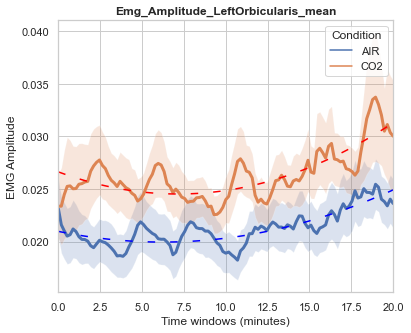

In [365]:
# Loop through each muscle column

for muscle_column in emg_mean_amp_columns:
    # Perform regression tests with polynomial features
    air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(amp_air_windows, amp_co2_windows, amp_data_windows, muscle_column, 2)
        
    # Create and save the time series plot
    Plots.features_time_series(gas_inhalation_windows, muscle_column, muscle_column, 'Time windows (minutes)', 'EMG Amplitude', os.path.join(notebook_temp_dir, muscle_column), air_prediction_line, co2_prediction_line)

# Gyro

In [45]:
# Gyroscope
gyro_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Gyroscope)').reset_index(drop=True)

gyro_air_segments = gyro_data_segments[gyro_data_segments['Condition']=='AIR']
gyro_co2_segments = gyro_data_segments[gyro_data_segments['Condition']=='CO2']

gyro_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Gyroscope)').reset_index(drop=True)
gyro_air_windows = gyro_data_windows[gyro_data_windows['Condition']=='AIR']
gyro_co2_windows = gyro_data_windows[gyro_data_windows['Condition']=='CO2']


#participant_counts = gyro_data_windows['participant_number'].value_counts()
#filtered_participants = participant_counts[participant_counts == 230].index.tolist()
#filtered_data = gyro_data_windows[gyro_data_windows['participant_number'].isin(filtered_participants)]


#gyro_air_windows = filtered_data[filtered_data['Condition']=='AIR']
#gyro_co2_windows = filtered_data[filtered_data['Condition']=='CO2']

In [46]:
import math

def get_magnitude_gyr(row):
    x = row['Gyroscope_Raw.x_mean']
    y = row['Gyroscope_Raw.y_mean']
    z = row['Gyroscope_Raw.z_mean']
    return math.sqrt((x**2) + (y**2) + (z**2))

gyro_data_segments['gyro_mean_magnitude'] = gyro_data_segments.apply(get_magnitude_gyr, axis=1)

In [47]:
Plots.segment_violin(gyro_data_segments, 'gyro_mean_magnitude', 'Gyroscope Magnitude for Air and CO2 Conditions', 'Condition', 'Gyroscope magnitude', 
                    notebook_temp_dir)

In [503]:
from scipy.stats import ttest_ind

# Extract data for AIR and CO2 conditions
air_condition = gyro_data_segments[gyro_data_segments['Condition'] == 'AIR']['gyro_mean_magnitude']
co2_condition = gyro_data_segments[gyro_data_segments['Condition'] == 'CO2']['gyro_mean_magnitude']

# Perform independent samples t-test
t_statistic, p_value = ttest_ind(air_condition, co2_condition)

# Display the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Check if the difference is statistically significant
alpha = 0.05
if p_value < alpha:
    print('The difference is statistically significant (reject the null hypothesis)')
else:
    print('The difference is not statistically significant (fail to reject the null hypothesis)')

T-statistic: 0.0017316064137597284
P-value: 0.9986222111080809
The difference is not statistically significant (fail to reject the null hypothesis)


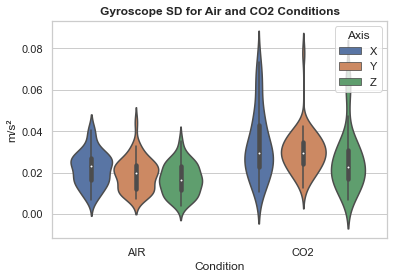

In [471]:
# Example usage
gyro_axes = ['Gyroscope_Raw.x_std', 'Gyroscope_Raw.y_std', 'Gyroscope_Raw.z_std']
Plots.segment_violin_imu(gyro_data_segments, gyro_axes, 'Gyroscope SD for Air and CO2 Conditions', 'Condition', 'm/s²', notebook_temp_dir)

In [48]:
import numpy as np
from scipy.optimize import curve_fit

# Your existing code for plotting lines
filtered_data['gyro_mean_magnitude'] = filtered_data.apply(get_magnitude_gyr, axis=1)

lines = []
plt.figure(figsize=(6, 5))
# 23 peter h, 34_benjamin_pomeroy, 51_marton_nagy

plot_title = 'Gyroscope Magnitude Mean Over Time'
mean_contact = filtered_data.groupby(['Condition', 'window_index']).agg({'gyro_mean_magnitude': 'mean'}).reset_index()
mean_contact_air = mean_contact[mean_contact['Condition']=='AIR']
mean_contact_co2 = mean_contact[mean_contact['Condition']=='CO2']
mean_contact_co2['condition_index'] = (mean_contact_co2.groupby('Condition').cumcount() / mean_contact_co2['window_index'].max()) * 20

mean_contact_air['condition_index'] = (mean_contact_air.groupby('Condition').cumcount() / mean_contact_air['window_index'].max()) * 20
line, = plt.plot(mean_contact_air['condition_index'], mean_contact_air['gyro_mean_magnitude'], linewidth=3, label='AIR')
lines.append(line)
line, = plt.plot(mean_contact_co2['condition_index'], mean_contact_co2['gyro_mean_magnitude'], linewidth=3, label='CO2')
lines.append(line)

# Curve fitting function (quadratic)
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

# Initial guess for the parameters
initial_guess = [1, 1, 1]

# Fit the curve for AIR condition
popt_air, _ = curve_fit(quadratic_func, mean_contact_air['condition_index'], mean_contact_air['gyro_mean_magnitude'], p0=initial_guess)

# Fit the curve for CO2 condition
popt_co2, _ = curve_fit(quadratic_func, mean_contact_co2['condition_index'], mean_contact_co2['gyro_mean_magnitude'], p0=initial_guess)

# Print the equations
equation_air = f'AIR: {popt_air[0]} * x^2 + {popt_air[1]} * x + {popt_air[2]}'
equation_co2 = f'CO2: {popt_co2[0]} * x^2 + {popt_co2[1]} * x + {popt_co2[2]}'

print('Quadratic Fit Equations:')
print(equation_air)
print(equation_co2)

# Plot the fitted curves
plt.plot(mean_contact_air['condition_index'], quadratic_func(mean_contact_air['condition_index'], *popt_air), '--', color='blue', linewidth='3', label='Fitted AIR')
plt.plot(mean_contact_co2['condition_index'], quadratic_func(mean_contact_co2['condition_index'], *popt_co2), '--', color='red', linewidth='3',  label='Fitted CO2')

plt.legend(handles=lines, title='Condition')
plt.xlabel('Time (minutes)')
plt.ylabel('Gyroscope magnitude')

#plt.title('Mean Gyroscope Magnitude with Quadratic Fitted Lines', weight='bold')
plt.savefig(os.path.join(notebook_temp_dir, "gyroscope_time_windows_with_quadratic_fit"))
plt.show()



Quadratic Fit Equations:
AIR: -1.105429020016502e-06 * x^2 + 2.621156583977779e-05 * x + 0.8943847090210042
CO2: -5.723687368157276e-07 * x^2 + 1.659196381184048e-05 * x + 0.8944007568038146


C:\Users\masqu\AppData\Local\Temp\ipykernel_23924\2044628131.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_contact_co2['condition_index'] = (mean_contact_co2.groupby('Condition').cumcount() / mean_contact_co2['window_index'].max()) * 20
C:\Users\masqu\AppData\Local\Temp\ipykernel_23924\2044628131.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_contact_air['condition_index'] = (mean_contact_air.groupby('Condition').cumcount() / mean_contact_air['window_index'].max()) * 20


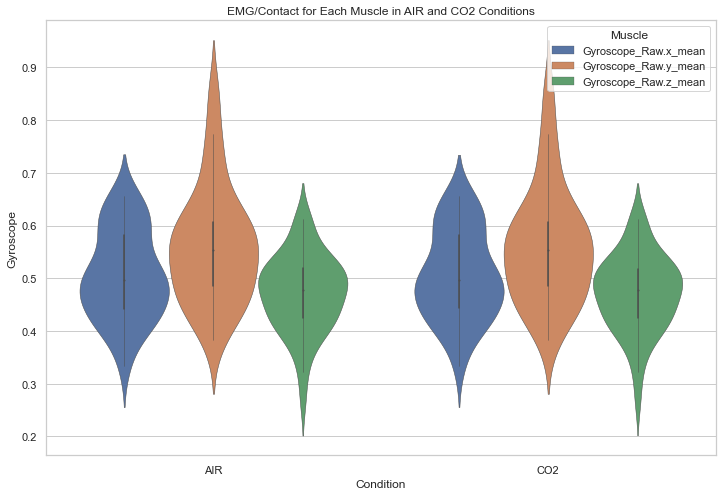

In [374]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = gyro_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=['Gyroscope_Raw.x_mean', 'Gyroscope_Raw.y_mean', 'Gyroscope_Raw.z_mean'])

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='value', hue='variable', data=melted_data, scale='width', linewidth=0.5)

# Customize the plot
plt.title('EMG/Contact for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('Gyroscope')
plt.legend(title='Muscle')

plt.savefig(os.path.join(notebook_temp_dir, "gyroscope_segments"))
# Show the plot
plt.show()


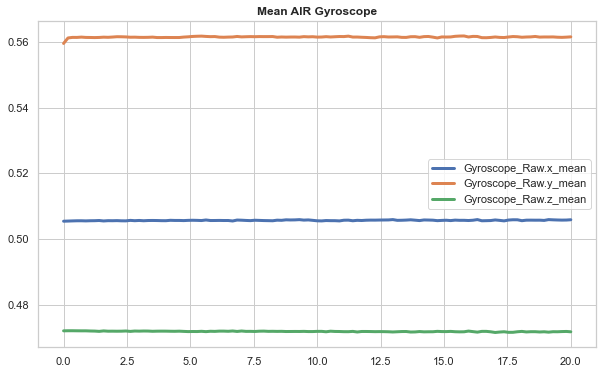

In [375]:
Plots.imu_gyro(gyro_air_windows, os.path.join(notebook_temp_dir, "air_gyro_windowed"))

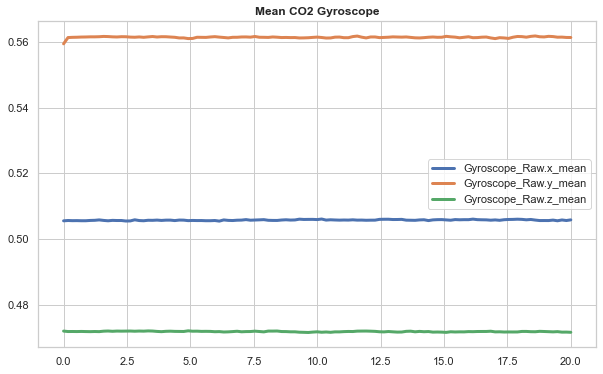

In [376]:
Plots.imu_gyro(gyro_co2_windows, os.path.join(notebook_temp_dir, "co2_gyro_windowed"))

In [473]:
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA

# Load your dataset for air and CO2 conditions
# Assuming your dataset is named 'gyro_data'
# Make sure 'Condition' is a categorical variable (air or CO2)

# Select the relevant features for the analysis
features = gyro_air_segments.columns[3:]

string = 'Gyroscope_Raw_x_mean + Gyroscope_Raw_x_std + Gyroscope_Raw_x_min + Gyroscope_Raw_x_max + Gyroscope_Raw_x_median + Gyroscope_Raw_x_range + Gyroscope_Raw_x_iqr + Gyroscope_Raw_x_1st_derivative_mean + Gyroscope_Raw_x_1st_derivative_std + Gyroscope_Raw_x_2nd_derivative_mean + Gyroscope_Raw_x_2nd_derivative_std + Gyroscope_Raw_y_mean + Gyroscope_Raw_y_std + Gyroscope_Raw_y_min + Gyroscope_Raw_y_max + Gyroscope_Raw_y_median + Gyroscope_Raw_y_range + Gyroscope_Raw_y_iqr + Gyroscope_Raw_y_1st_derivative_mean + Gyroscope_Raw_y_1st_derivative_std + Gyroscope_Raw_y_2nd_derivative_mean + Gyroscope_Raw_y_2nd_derivative_std + Gyroscope_Raw_z_mean + Gyroscope_Raw_z_std + Gyroscope_Raw_z_min + Gyroscope_Raw_z_max + Gyroscope_Raw_z_median + Gyroscope_Raw_z_range + Gyroscope_Raw_z_iqr + Gyroscope_Raw_z_1st_derivative_mean + Gyroscope_Raw_z_1st_derivative_std + Gyroscope_Raw_z_2nd_derivative_mean + Gyroscope_Raw_z_2nd_derivative_std'

#features = gyro_air_segments.columns[3:]
# Create a new DataFrame for MANOVA
manova_data = pd.concat([gyro_air_segments, gyro_co2_segments])
manova_data.columns = [col.replace('.', '_') for col in manova_data.columns]


# Add a column to indicate the condition
#manova_data['Condition'] = ['Air'] * len(gyro_air_segments) + ['CO2'] * len(gyro_co2_segments)

# Perform MANOVA
#manova = MANOVA.from_formula(manova_data[features], groups=manova_data['Condition'])
manova = MANOVA.from_formula(string + ' ~ Condition', data=manova_data)
manova_results = manova.mv_test()

# Print the results
print(manova_results)

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value    Num DF  Den DF F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda   0.0042 28.0000 63.0000 527.8903 0.0000
         Pillai's trace   1.4023 28.0000 63.0000  -7.8435 1.0000
 Hotelling-Lawley trace 138.8403 28.0000 63.0000 312.3908 0.0000
    Roy's greatest root 138.1470 28.0000 63.0000 310.8309 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
          Condition        Value   Num DF  Den DF F Value Pr > F
----------------------------------------------------------------
             Wilks' lambda 0.3620 30.0000 61.0000  3.5833 0.0000
            Pillai's trace 0.6416 30.0000 61.

In [474]:
# Extract the list of dependent variables (features)
dependent_vars = manova_data.columns[3:]

alpha = 0.05
number_of_tests = len(dependent_vars)

bonferroni_adjusted_alpha = alpha / number_of_tests
count_of_significant = 0

# Perform Univariate Follow-Up ANOVA Tests
univariate_results = {}
for var in dependent_vars:
    anova = manova_data[[var, 'Condition']].dropna()
    anova_groups = [manova_data[var][anova['Condition'] == condition] for condition in anova['Condition'].unique()]
    f_statistic, p_value = stats.f_oneway(*anova_groups)
    univariate_results[var] = {'F-statistic': f_statistic, 'p-value': p_value}

# Print Univariate Follow-Up ANOVA Results
for var, result in univariate_results.items():
    print(f"Variable: {var}")
    print(f"F-statistic: {result['F-statistic']:.4f}, p-value: {result['p-value']*number_of_tests:.4f}")
    if(result['p-value']<bonferroni_adjusted_alpha):
        print('Significant\n')
        count_of_significant = count_of_significant + 1
    else:
        print('Not Significant\n')

print('Count of Significant results: ' + str(count_of_significant))


Variable: Gyroscope_Raw_x_mean
F-statistic: 0.0000, p-value: 32.8831
Not Significant

Variable: Gyroscope_Raw_x_std
F-statistic: 18.1446, p-value: 0.0017
Significant

Variable: Gyroscope_Raw_x_min
F-statistic: 1.9361, p-value: 5.5281
Not Significant

Variable: Gyroscope_Raw_x_max
F-statistic: 0.7147, p-value: 13.2044
Not Significant

Variable: Gyroscope_Raw_x_median
F-statistic: 0.0000, p-value: 32.8788
Not Significant

Variable: Gyroscope_Raw_x_range
F-statistic: 1.6544, p-value: 6.6550
Not Significant

Variable: Gyroscope_Raw_x_iqr
F-statistic: 19.2443, p-value: 0.0010
Significant

Variable: Gyroscope_Raw_x_1st_derivative_mean
F-statistic: 0.8239, p-value: 12.0933
Not Significant

Variable: Gyroscope_Raw_x_1st_derivative_std
F-statistic: 14.6701, p-value: 0.0078
Significant

Variable: Gyroscope_Raw_x_2nd_derivative_mean
F-statistic: 0.1290, p-value: 23.7708
Not Significant

Variable: Gyroscope_Raw_x_2nd_derivative_std
F-statistic: 13.8404, p-value: 0.0114
Significant

Variable: Gyros

In [475]:
for column in gyro_air_segments.columns[3:]:
    print(f"\nColumn: {column}")
    Tests.paired_t_test(gyro_air_segments[column], gyro_co2_segments[column])


Column: Gyroscope_Raw.x_mean
T-statistic: -0.496
P-value: 0.622
No singificant results found.

Column: Gyroscope_Raw.x_std
T-statistic: -4.921
P-value: 0.000
SIGNIFICANT difference found.

Column: Gyroscope_Raw.x_min
T-statistic: 1.342
P-value: 0.186
No singificant results found.

Column: Gyroscope_Raw.x_max
T-statistic: -0.770
P-value: 0.445
No singificant results found.

Column: Gyroscope_Raw.x_median
T-statistic: -0.405
P-value: 0.688
No singificant results found.

Column: Gyroscope_Raw.x_range
T-statistic: -1.138
P-value: 0.261
No singificant results found.

Column: Gyroscope_Raw.x_iqr
T-statistic: -8.659
P-value: 0.000
SIGNIFICANT difference found.

Column: Gyroscope_Raw.x_1st_derivative_mean
T-statistic: 0.858
P-value: 0.395
No singificant results found.

Column: Gyroscope_Raw.x_1st_derivative_std
T-statistic: -6.144
P-value: 0.000
SIGNIFICANT difference found.

Column: Gyroscope_Raw.x_2nd_derivative_mean
T-statistic: 0.387
P-value: 0.701
No singificant results found.

Column: G

# ACC

In [49]:
# Accelerometer
acc_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Accelerometer)').reset_index(drop=True)

acc_air_segments = acc_data_segments[acc_data_segments['Condition']=='AIR']
acc_co2_segments = acc_data_segments[acc_data_segments['Condition']=='CO2']

acc_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Accelerometer)').reset_index(drop=True)
acc_air_windows = acc_data_windows[acc_data_windows['Condition']=='AIR']
acc_co2_windows = acc_data_windows[acc_data_windows['Condition']=='CO2']

In [50]:
# Accelerometer
acc_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Accelerometer)').reset_index(drop=True)

acc_air_segments = acc_data_segments[acc_data_segments['Condition']=='AIR']
acc_co2_segments = acc_data_segments[acc_data_segments['Condition']=='CO2']

acc_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Accelerometer)').reset_index(drop=True)
acc_air_windows = acc_data_windows[acc_data_windows['Condition']=='AIR']
acc_co2_windows = acc_data_windows[acc_data_windows['Condition']=='CO2']


participant_counts = acc_data_windows['participant_number'].value_counts()
filtered_participants = participant_counts[participant_counts == 230].index.tolist()
filtered_data = acc_data_windows[acc_data_windows['participant_number'].isin(filtered_participants)]
acc_data_windows = filtered_data


acc_air_windows = filtered_data[filtered_data['Condition']=='AIR']
acc_co2_windows = filtered_data[filtered_data['Condition']=='CO2']

In [51]:
import math

def get_magnitude_acc(row):
    x = row['Accelerometer_Raw.x_std']
    y = row['Accelerometer_Raw.y_std']
    z = row['Accelerometer_Raw.z_std']
    return math.sqrt((x**2) + (y**2) + (z**2))

acc_data_segments['acc_mean_magnitude'] = acc_data_segments.apply(get_magnitude_acc, axis=1)

In [52]:
import numpy as np
from scipy.optimize import curve_fit

# Your existing code for plotting lines
acc_data_windows['acc_mean_magnitude'] = acc_data_windows.apply(get_magnitude_acc, axis=1)

lines = []
plt.figure(figsize=(6, 5))

plot_title = 'Accelerometer Magnitude Mean Over Time'
mean_contact = acc_data_windows.groupby(['Condition', 'window_index']).agg({'acc_mean_magnitude': 'mean'}).reset_index()
mean_contact_air = mean_contact[mean_contact['Condition']=='AIR']
mean_contact_co2 = mean_contact[mean_contact['Condition']=='CO2']
mean_contact_co2['condition_index'] = (mean_contact_co2.groupby('Condition').cumcount() / mean_contact_co2['window_index'].max()) * 20

mean_contact_air['condition_index'] = (mean_contact_air.groupby('Condition').cumcount() / mean_contact_air['window_index'].max()) * 20
line, = plt.plot(mean_contact_air['condition_index'], mean_contact_air['acc_mean_magnitude'], linewidth=3, label='AIR')
lines.append(line)
line, = plt.plot(mean_contact_co2['condition_index'], mean_contact_co2['acc_mean_magnitude'], linewidth=3, label='CO2')
lines.append(line)

# Curve fitting function (quadratic)
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

# Initial guess for the parameters
initial_guess = [1, 1, 1]

# Fit the curve for AIR condition
popt_air, _ = curve_fit(quadratic_func, mean_contact_air['condition_index'], mean_contact_air['acc_mean_magnitude'], p0=initial_guess)

# Fit the curve for CO2 condition
popt_co2, _ = curve_fit(quadratic_func, mean_contact_co2['condition_index'], mean_contact_co2['acc_mean_magnitude'], p0=initial_guess)

# Print the equations
equation_air = f'AIR: {popt_air[0]} * x^2 + {popt_air[1]} * x + {popt_air[2]}'
equation_co2 = f'CO2: {popt_co2[0]} * x^2 + {popt_co2[1]} * x + {popt_co2[2]}'

print('Quadratic Fit Equations:')
print(equation_air)
print(equation_co2)

# Plot the fitted curves
plt.plot(mean_contact_air['condition_index'], quadratic_func(mean_contact_air['condition_index'], *popt_air), '--', color='blue', linewidth='3', label='Fitted AIR')
plt.plot(mean_contact_co2['condition_index'], quadratic_func(mean_contact_co2['condition_index'], *popt_co2), '--', color='red', linewidth='3',  label='Fitted CO2')

plt.legend(handles=lines, title='Condition')
plt.xlabel('Time (minutes)')
plt.ylabel('Accelerometer magnitude')

#plt.title('Mean Accelerometer Magnitude with Quadratic Fitted Lines', weight='bold')
plt.savefig(os.path.join(notebook_temp_dir, "accelerometer_time_windows_with_quadratic_fit"))
plt.show()



Quadratic Fit Equations:
AIR: 4.742796658225369e-05 * x^2 + 0.000709077531415599 * x + 0.04942626723306839
CO2: -0.00012663735202243822 * x^2 + 0.0052323403248558205 * x + 0.054575952079880516


C:\Users\masqu\AppData\Local\Temp\ipykernel_23924\2726112009.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_contact_co2['condition_index'] = (mean_contact_co2.groupby('Condition').cumcount() / mean_contact_co2['window_index'].max()) * 20
C:\Users\masqu\AppData\Local\Temp\ipykernel_23924\2726112009.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_contact_air['condition_index'] = (mean_contact_air.groupby('Condition').cumcount() / mean_contact_air['window_index'].max()) * 20


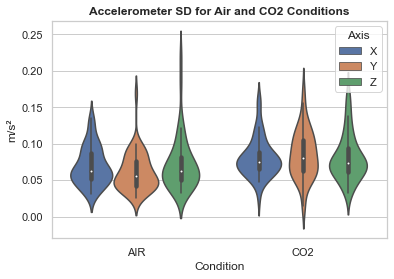

In [199]:
# Example usage
gyro_axes = ['Accelerometer_Raw.x_std', 'Accelerometer_Raw.y_std', 'Accelerometer_Raw.z_std']
Plots.segment_violin_imu(acc_data_segments, gyro_axes, 'Accelerometer SD for Air and CO2 Conditions', 'Condition', 'm/s²', notebook_temp_dir)

In [53]:
Plots.segment_violin(acc_data_segments, 'acc_mean_magnitude', 'Accelerometer Magnitude for Air and CO2 Conditions', 'Condition', 'Accelerometer magnitude', 
                    notebook_temp_dir)

In [498]:
from scipy.stats import ttest_ind

# Extract data for AIR and CO2 conditions
air_condition = acc_data_segments[acc_data_segments['Condition'] == 'AIR']['acc_mean_magnitude']
co2_condition = acc_data_segments[acc_data_segments['Condition'] == 'CO2']['acc_mean_magnitude']

# Perform independent samples t-test
t_statistic, p_value = ttest_ind(air_condition, co2_condition)

# Display the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Check if the difference is statistically significant
alpha = 0.05
if p_value < alpha:
    print('The difference is statistically significant (reject the null hypothesis)')
else:
    print('The difference is not statistically significant (fail to reject the null hypothesis)')

T-statistic: -3.098326369343997
P-value: 0.002596549881668668
The difference is statistically significant (reject the null hypothesis)


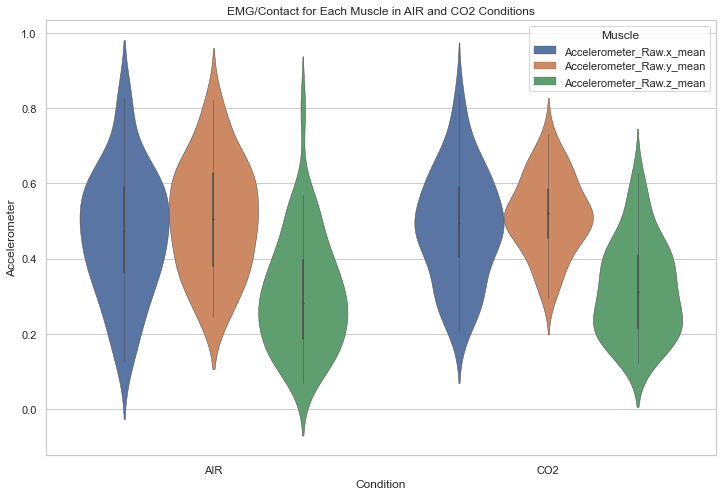

In [386]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = acc_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=['Accelerometer_Raw.x_mean', 'Accelerometer_Raw.y_mean', 'Accelerometer_Raw.z_mean'])

# Define the order of the muscles for plotting
muscle_order = ['RightOrbicularis', 'RightZygomaticus', 'RightFrontalis', 'CenterCorrugator', 'LeftFrontalis', 'LeftZygomaticus', 'LeftOrbicularis']

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='value', hue='variable', data=melted_data, scale='width', linewidth=0.5)

# Customize the plot
plt.title('EMG/Contact for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('Accelerometer')
plt.legend(title='Muscle')

plt.savefig(os.path.join(notebook_temp_dir, "accelerometer_segments"))
# Show the plot
plt.show()


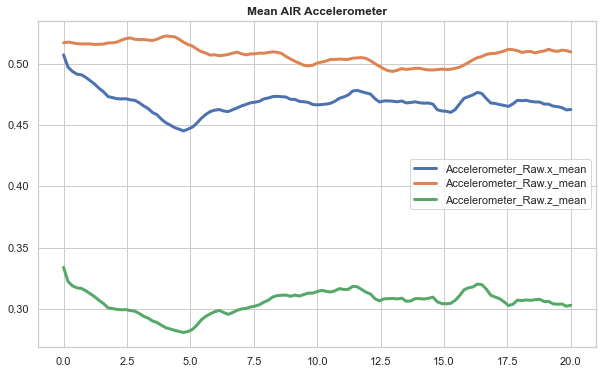

In [387]:
Plots.imu_acc(acc_air_windows, os.path.join(notebook_temp_dir, "air_acc_windowed"))

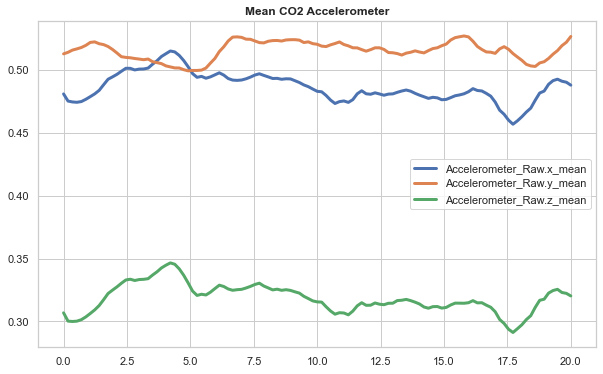

In [388]:
Plots.imu_acc(acc_co2_windows, os.path.join(notebook_temp_dir, "co2_acc_windowed"))

In [389]:
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA

# Load your dataset for air and CO2 conditions
# Assuming your dataset is named 'gyro_data'
# Make sure 'Condition' is a categorical variable (air or CO2)

# Select the relevant features for the analysis
features = acc_air_segments.columns[3:]

string = 'Accelerometer_Raw_x_mean + Accelerometer_Raw_x_std + Accelerometer_Raw_x_min + Accelerometer_Raw_x_max + Accelerometer_Raw_x_median + Accelerometer_Raw_x_range + Accelerometer_Raw_x_iqr + Accelerometer_Raw_x_1st_derivative_mean + Accelerometer_Raw_x_1st_derivative_std + Accelerometer_Raw_x_2nd_derivative_mean + Accelerometer_Raw_x_2nd_derivative_std + Accelerometer_Raw_y_mean + Accelerometer_Raw_y_std + Accelerometer_Raw_y_min + Accelerometer_Raw_y_max + Accelerometer_Raw_y_median + Accelerometer_Raw_y_range + Accelerometer_Raw_y_iqr + Accelerometer_Raw_y_1st_derivative_mean + Accelerometer_Raw_y_1st_derivative_std + Accelerometer_Raw_y_2nd_derivative_mean + Accelerometer_Raw_y_2nd_derivative_std + Accelerometer_Raw_z_mean + Accelerometer_Raw_z_std + Accelerometer_Raw_z_min + Accelerometer_Raw_z_max + Accelerometer_Raw_z_median + Accelerometer_Raw_z_range + Accelerometer_Raw_z_iqr + Accelerometer_Raw_z_1st_derivative_mean + Accelerometer_Raw_z_1st_derivative_std + Accelerometer_Raw_z_2nd_derivative_mean + Accelerometer_Raw_z_2nd_derivative_std'

#features = gyro_air_segments.columns[3:]
# Create a new DataFrame for MANOVA
manova_data = pd.concat([acc_air_segments, acc_co2_segments])
manova_data.columns = [col.replace('.', '_') for col in manova_data.columns]


# Add a column to indicate the condition
#manova_data['Condition'] = ['Air'] * len(gyro_air_segments) + ['CO2'] * len(gyro_co2_segments)

# Perform MANOVA
#manova = MANOVA.from_formula(manova_data[features], groups=manova_data['Condition'])
manova = MANOVA.from_formula(string + ' ~ Condition', data=manova_data)
manova_results = manova.mv_test()

# Print the results
print(manova_results)

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value    Num DF  Den DF F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda   0.0082 28.0000 63.0000 272.3708 0.0000
         Pillai's trace   0.9918 28.0000 63.0000 272.3708 0.0000
 Hotelling-Lawley trace 121.0537 28.0000 63.0000 272.3708 0.0000
    Roy's greatest root 121.0537 28.0000 63.0000 272.3708 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
          Condition        Value   Num DF  Den DF F Value Pr > F
----------------------------------------------------------------
             Wilks' lambda 0.4148 30.0000 61.0000  2.8689 0.0002
            Pillai's trace 0.6247 30.0000 61.

In [390]:
# Extract the list of dependent variables (features)
dependent_vars = manova_data.columns[3:]

alpha = 0.05
number_of_tests = len(dependent_vars)

bonferroni_adjusted_alpha = alpha / number_of_tests
count_of_significant = 0

# Perform Univariate Follow-Up ANOVA Tests
univariate_results = {}
for var in dependent_vars:
    anova = manova_data[[var, 'Condition']].dropna()
    anova_groups = [manova_data[var][anova['Condition'] == condition] for condition in anova['Condition'].unique()]
    f_statistic, p_value = stats.f_oneway(*anova_groups)
    univariate_results[var] = {'F-statistic': f_statistic, 'p-value': p_value}

# Print Univariate Follow-Up ANOVA Results
for var, result in univariate_results.items():
    print(f"Variable: {var}")
    print(f"F-statistic: {result['F-statistic']:.4f}, p-value: {result['p-value']*number_of_tests:.4f}")
    if(result['p-value']<bonferroni_adjusted_alpha):
        print('Significant\n')
        count_of_significant = count_of_significant + 1
    else:
        print('Not Significant\n')

print('Count of Significant results: ' + str(count_of_significant))


Variable: Accelerometer_Raw_x_mean
F-statistic: 0.2778, p-value: 19.7822
Not Significant

Variable: Accelerometer_Raw_x_std
F-statistic: 4.3204, p-value: 1.3367
Not Significant

Variable: Accelerometer_Raw_x_min
F-statistic: 2.8498, p-value: 3.1300
Not Significant

Variable: Accelerometer_Raw_x_max
F-statistic: 1.2674, p-value: 8.6874
Not Significant

Variable: Accelerometer_Raw_x_median
F-statistic: 0.2839, p-value: 19.6507
Not Significant

Variable: Accelerometer_Raw_x_range
F-statistic: 4.4175, p-value: 1.2661
Not Significant

Variable: Accelerometer_Raw_x_iqr
F-statistic: 3.9499, p-value: 1.6472
Not Significant

Variable: Accelerometer_Raw_x_1st_derivative_mean
F-statistic: 0.3759, p-value: 17.8641
Not Significant

Variable: Accelerometer_Raw_x_1st_derivative_std
F-statistic: 37.0246, p-value: 0.0000
Significant

Variable: Accelerometer_Raw_x_2nd_derivative_mean
F-statistic: 1.0356, p-value: 10.2822
Not Significant

Variable: Accelerometer_Raw_x_2nd_derivative_std
F-statistic: 36.8

# Correlation Matrix

F:\co2-study\utils\Tests.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={


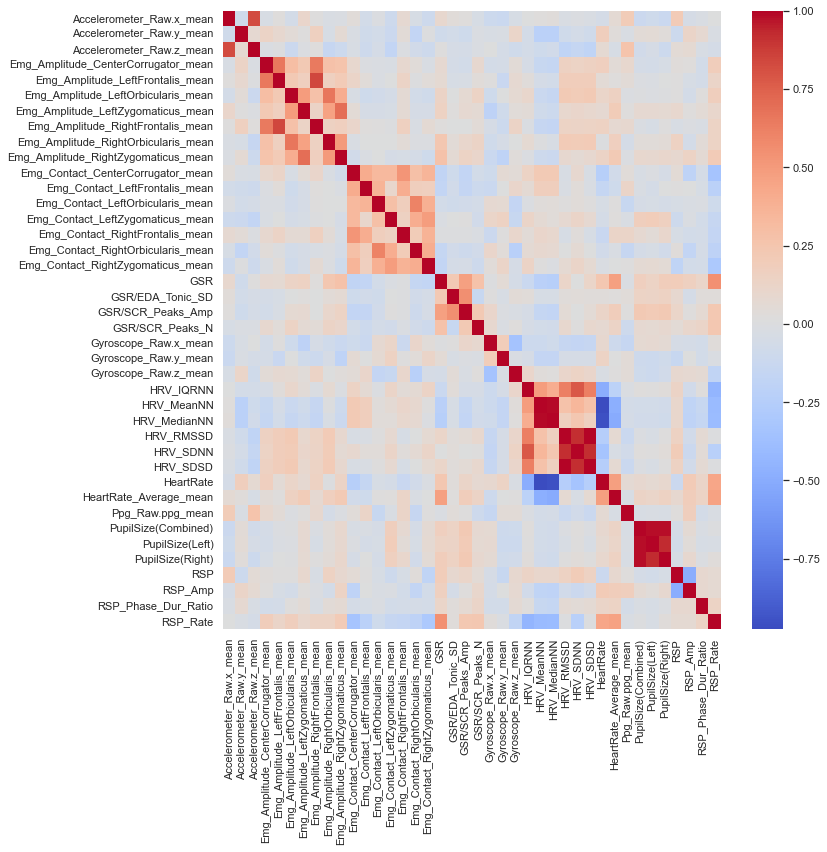

In [398]:
correlation_data = Tests.correlation_test(gas_inhalation_windows)
Plots.correlation_heatmap(correlation_data, os.path.join(notebook_temp_dir, "correlation_heatmap"))